In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import math

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", valid=False, normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        
        if valid:
            idx = int(len(inputs) * .8)
            return inputs[:idx], inputs[idx:], outputs[:idx], outputs[idx:]

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = (self.inputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ValidationDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, inputs, outputs, transform=None):
        super(ValidationDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = inputs, outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [3]:
batch_sz = 8  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz)

## Sample a batch of data and visualize 

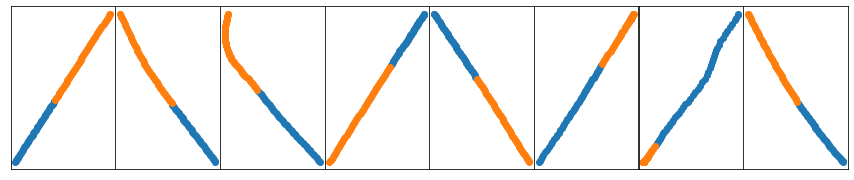

In [4]:
import matplotlib.pyplot as plt
import random

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        #first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    # inp[i] is a scene with 50 coordinates, input[i, j] is a coordinate
    # gotta loop through each scene in the batch
    inp, out = sample_batch # inp: (batch size, 50, 2), out: (batch size, 60, 2)
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

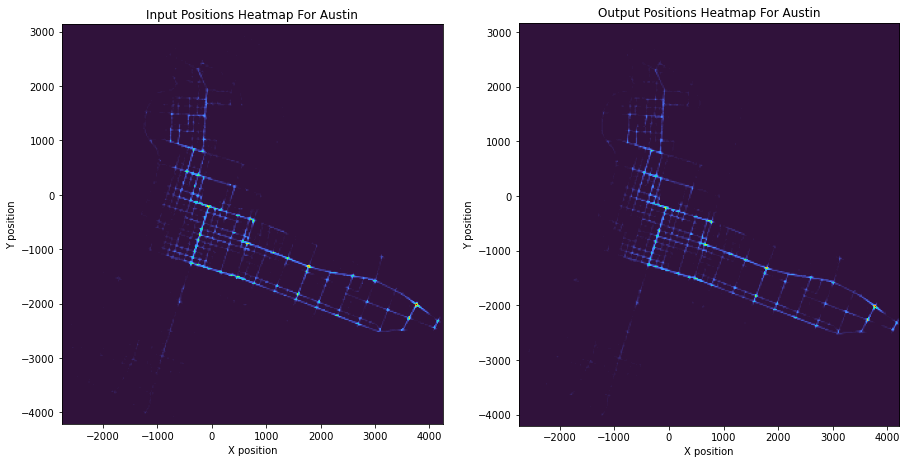

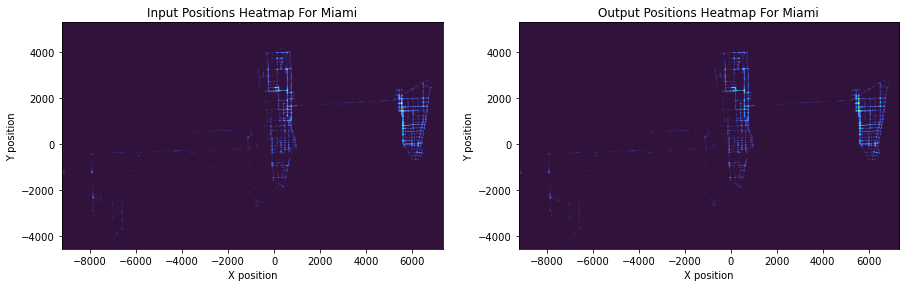

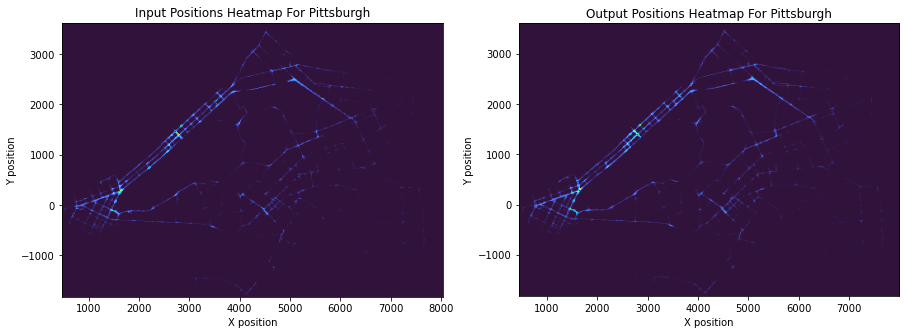

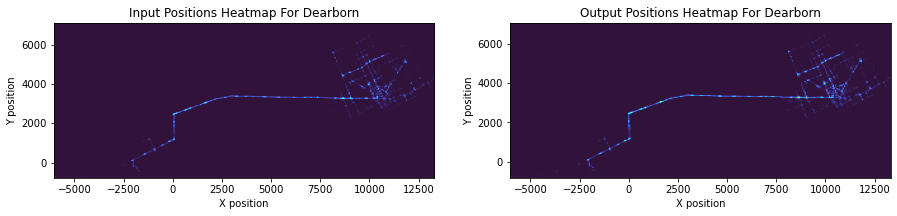

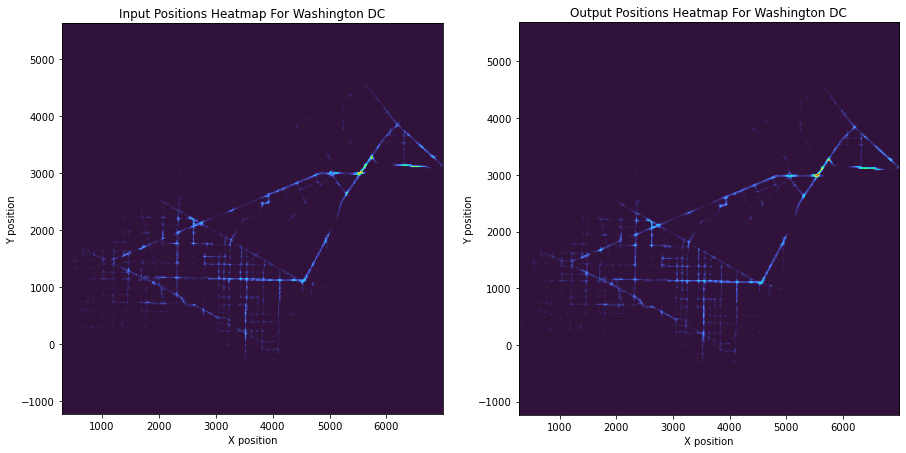

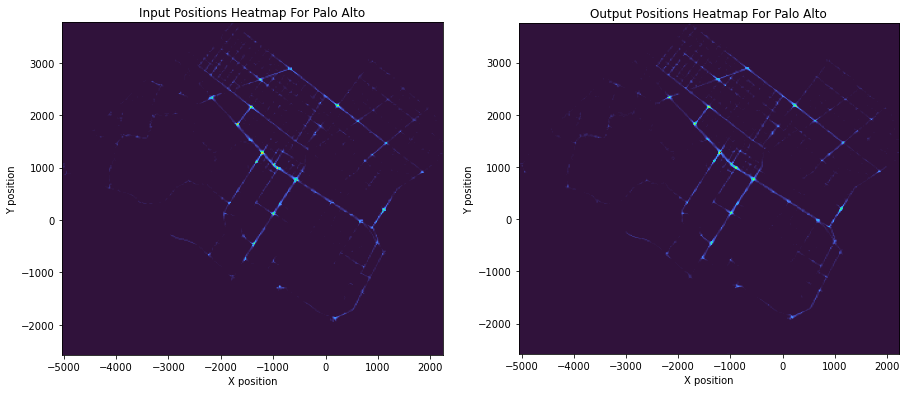

In [5]:
#source : https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr

city_names = ["Austin", "Miami", "Pittsburgh", "Dearborn", "Washington DC", "Palo Alto"]


for i, city in enumerate(cities):
    
    fig, axs = plt.subplots(ncols=2,figsize=(15, 10))
    
    inp, out = get_city_trajectories(city=city)
             
    x_in = [x.T[0] for i in inp for x in i]
    y_in = [x.T[1] for i in inp for x in i]
    x_out = [x.T[0] for i in out for x in i]
    y_out = [x.T[1] for i in out for x in i]
        
    heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)#jet
    axs[0].set_title(f'Input Positions Heatmap For {city_names[i]}')
    axs[0].set_xlabel(f'X position')
    axs[0].set_ylabel(f'Y position')
        
    heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
    axs[1].set_title(f'Output Positions Heatmap For {city_names[i]}')
    axs[1].set_xlabel(f'X position')
    axs[1].set_ylabel(f'Y position')
    
    fig.show();

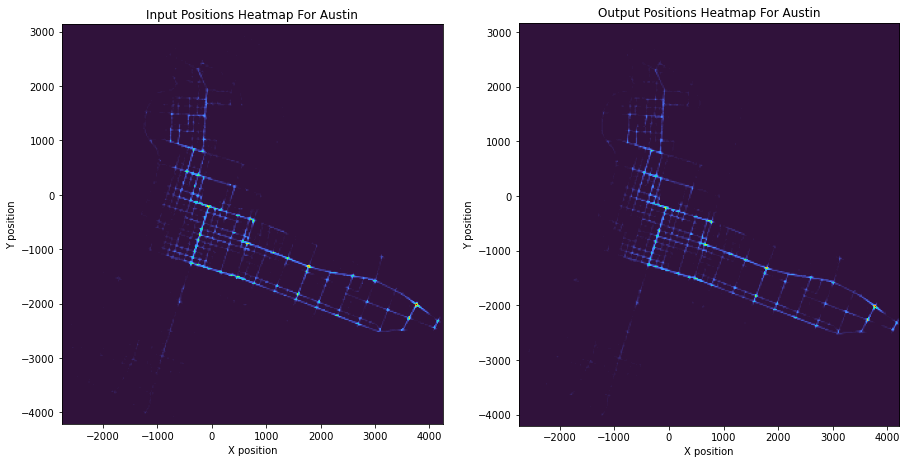

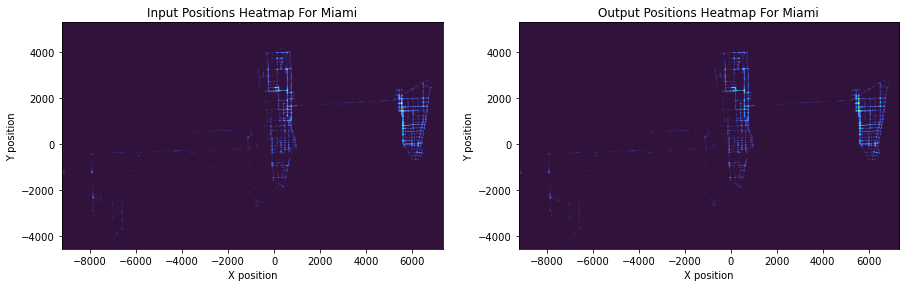

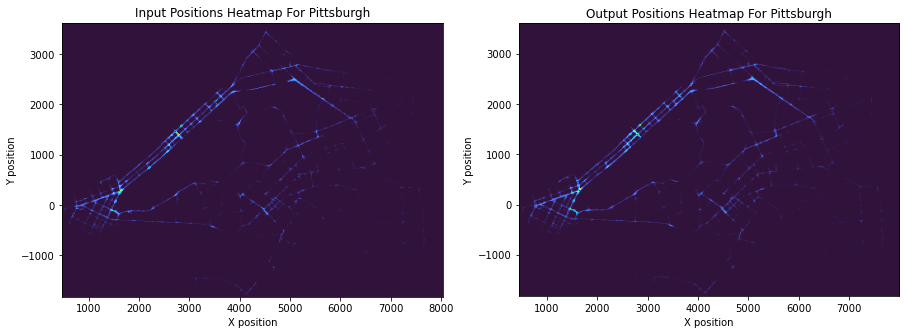

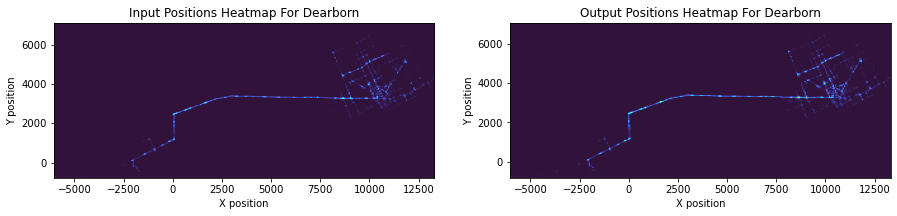

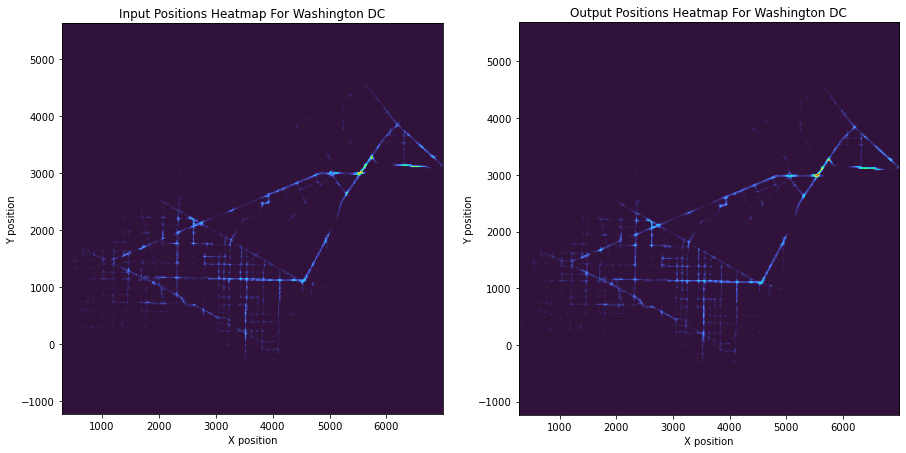

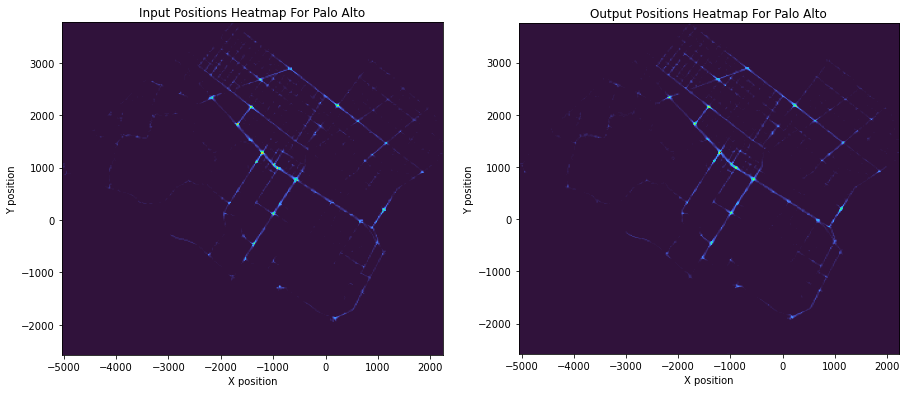

In [6]:
#source : https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr

city_names = ["Austin", "Miami", "Pittsburgh", "Dearborn", "Washington DC", "Palo Alto"]


for i, city in enumerate(cities):
    
    fig, axs = plt.subplots(ncols=2,figsize=(15, 10))
    
    inp, out = get_city_trajectories(city=city)
             
    x_in = [x.T[0] for i in inp for x in i]
    y_in = [x.T[1] for i in inp for x in i]
    x_out = [x.T[0] for i in out for x in i]
    y_out = [x.T[1] for i in out for x in i]
        
    heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)#jet
    axs[0].set_title(f'Input Positions Heatmap For {city_names[i]}')
    axs[0].set_xlabel(f'X position')
    axs[0].set_ylabel(f'Y position')
        
    heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
    axs[1].set_title(f'Output Positions Heatmap For {city_names[i]}')
    axs[1].set_xlabel(f'X position')
    axs[1].set_ylabel(f'Y position')
    
    fig.show();

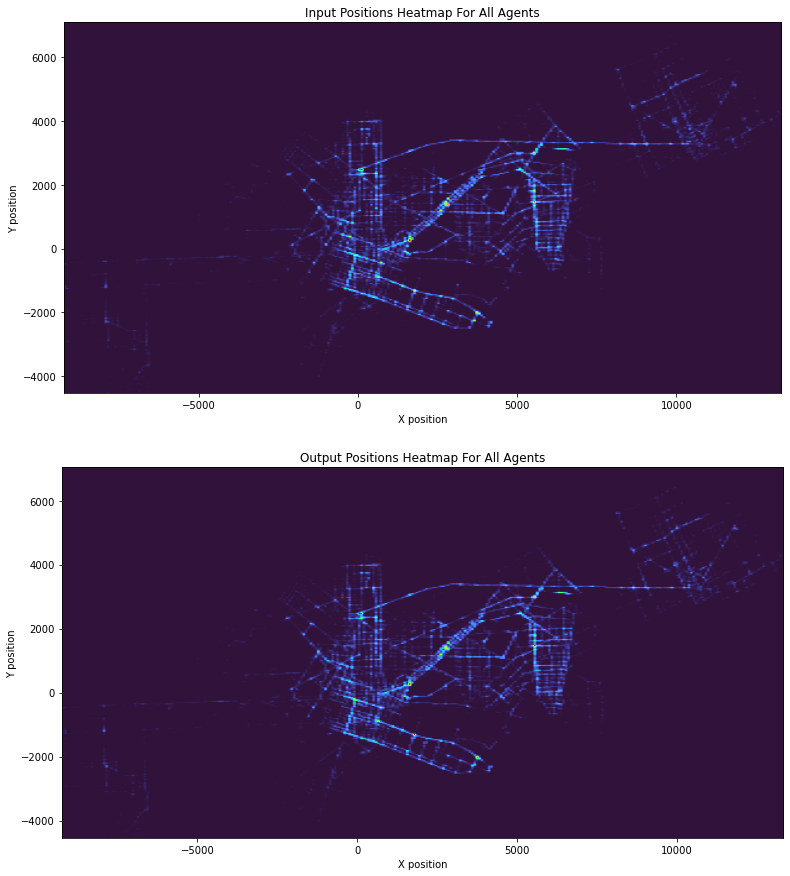

In [7]:
city = cities[0]

inp, out = get_city_trajectories(city=city)

fig, axs = plt.subplots(nrows=2,figsize=(15, 15))

for city in cities[1:]:
    
    i, o = get_city_trajectories(city=city)
    
    inp = np.concatenate((inp, i), axis=0)
    out = np.concatenate((out, o), axis=0)    
                 
x_in = [x.T[0] for i in inp for x in i]
y_in = [x.T[1] for i in inp for x in i]
x_out = [x.T[0] for i in out for x in i]
y_out = [x.T[1] for i in out for x in i]

heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)
axs[0].set_title(f'Input Positions Heatmap For All Agents')
axs[0].set_xlabel(f'X position')
axs[0].set_ylabel(f'Y position')

heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
axs[1].set_title(f'Output Positions Heatmap For All Agents')
axs[1].set_xlabel(f'X position')
axs[1].set_ylabel(f'Y position')

fig.show();

In [8]:
#!pip install cmasher

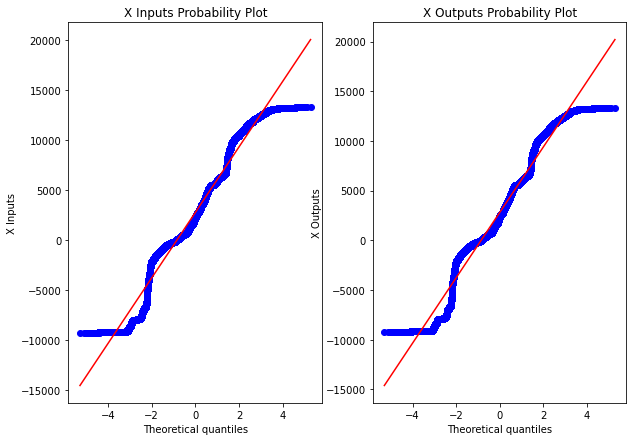

In [9]:
# import numpy as np 
import pylab 
import scipy.stats as stats

fig, axs = plt.subplots(ncols=2,figsize=(10, 7))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(x_in, dist="norm", plot=axs[0])
axs[0].set_ylabel('X Inputs')
axs[0].set_title('X Inputs Probability Plot')

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(x_out, dist="norm", plot=axs[1])
axs[1].set_ylabel('X Outputs')
axs[1].set_title('X Outputs Probability Plot')

fig.show()

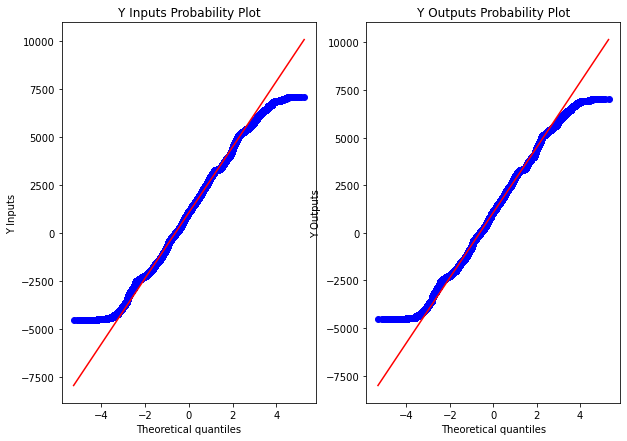

In [10]:
fig, axs = plt.subplots(ncols=2,figsize=(10, 7))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(y_in, dist="norm", plot=axs[0])
axs[0].set_ylabel('Y Inputs')
axs[0].set_title('Y Inputs Probability Plot')

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(y_out, dist="norm", plot=axs[1])
axs[1].set_ylabel('Y Outputs')
axs[1].set_title('Y Outputs Probability Plot')

fig.show()